<a href="https://colab.research.google.com/github/hamednasr/deep-learning/blob/main/my_code_transfer_learning_letters_to_numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split

# for importing data
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# use GPU if available
# device = 'cpu'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Import and inspect the data

In [3]:
trans = T.Compose([T.ToTensor()])

In [4]:
# download the dataset
letters_train = torchvision.datasets.EMNIST(root='emnist',split='letters',
                                            download=True,train=True,transform=trans)
numbers_train = torchvision.datasets.EMNIST(root='emnist',split='digits',
                                            download=True,train=True,transform=trans)

letters_test = torchvision.datasets.EMNIST(root='emnist',split='letters',
                                           download=True,train=False,transform=trans)
numbers_test = torchvision.datasets.EMNIST(root='emnist',split='digits',
                                           download=True,train=False,transform=trans)

# more info: https://www.nist.gov/itl/products-and-services/emnist-dataset

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting emnist/EMNIST/raw/gzip.zip to emnist/EMNIST/raw


In [5]:
letters_train.data.shape

torch.Size([124800, 28, 28])

In [6]:
numbers_train.data.shape

torch.Size([240000, 28, 28])

In [7]:
# inspect the data

# the categories (but how many letters??)
print(letters_train.classes)
print(str(len(letters_train.classes)) + ' classes')

print('\nData size:')
print(letters_train.data.shape)


['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size:
torch.Size([124800, 28, 28])


In [8]:
# brief aside: class 'N/A' doesn't exist in the data.
print( torch.sum(letters_train.targets==0) )

# However, it causes problems in one-hot encoding...
torch.unique(letters_train.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [9]:
# so therefore we'll eliminate it and subtract 1 from the original

# remove the first class category
letterCategories = letters_train.classes[1:]

# relabel labels to start at 0
letterlabels_train = copy.deepcopy(letters_train.targets)-1
letterlabels_test = copy.deepcopy(letters_test.targets)-1
print(letterlabels_train.shape)

### 
print( torch.sum(letterlabels_train==0) )
torch.unique(letterlabels_train)

torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

# Create train/test groups using DataLoader

In [10]:
letters_train.targets= letterlabels_train
letters_test.targets= letterlabels_test

In [11]:
# Step 4: translate into dataloader objects
batchsize    = 128
train_loader_letters = DataLoader(letters_train,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader_letters  = DataLoader(letters_test,batch_size=letters_test.data.shape[0])

train_loader_numbers = DataLoader(numbers_train,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader_numbers  = DataLoader(numbers_test,batch_size=numbers_test.data.shape[0])

In [12]:
train_loader_letters.dataset.targets

tensor([22,  6, 15,  ..., 12, 14, 18])

In [13]:
# check size (should be images X channels X width X height
print( train_loader_letters.dataset.data.shape )
print( test_loader_letters.dataset.data.shape )

torch.Size([124800, 28, 28])
torch.Size([20800, 28, 28])


# Create the DL model

In [14]:
# create a class for the model
def makeTheNet(C):

  class emnistnet(nn.Module):
    def __init__(self):
      super().__init__()


      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(1,6,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(6,6,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)

      
      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(7*7*6,50)
      self.fc2 = nn.Linear(50,C)

    def forward(self,x):
     
     
      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      
      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = self.fc2(x)

      return x

  # create the model instance
  net = emnistnet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [15]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(26)

X,y = iter(train_loader_letters).next()
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)


Output size:
torch.Size([128, 26])
 
Loss:
tensor(3.2341, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [16]:
# a function that trains the model

def function2trainTheModel(net,train_loader,test_loader,numepochs = 5):

  
  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)

    ### test performance
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)
      
    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net

# Run the model and show the results!

In [17]:
# create a new model
lettersnet,lossfun,optimizer = makeTheNet(26)
# ~2 minutes with 10 epochs on GPU (8 mins on the CPU!)
trainLoss,testLoss,trainErr,testErr,net = function2trainTheModel(lettersnet,train_loader_letters,test_loader_letters,5)

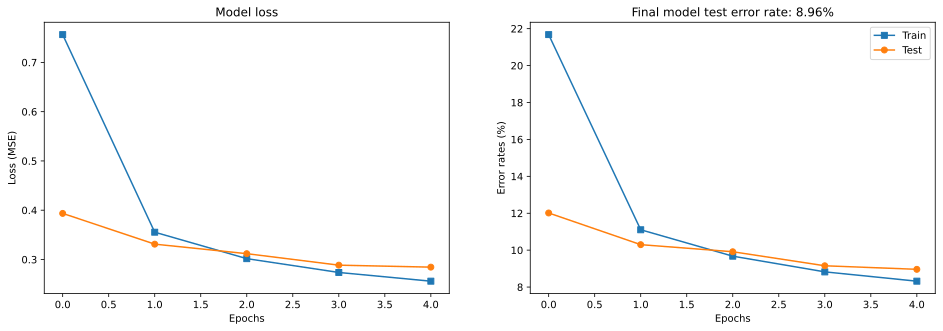

In [18]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

# Accuracy by letter

In [19]:
X,y = next(iter(test_loader_numbers))
X = X.to(device)
y = y.to(device)

lettersnet.eval()
yHat = lettersnet(X)

# the test
numbererr = 100*torch.mean((torch.argmax(yHat,axis=1)!=y).float())

print(f'letterNet error rate on NUMBER data: {numbererr:.2f}%')

letterNet error rate on NUMBER data: 96.25%


## without transfer learning:

In [45]:
# create a new model
numbersnet,lossfun,optimizer = makeTheNet(10)

# for target, source in zip(numbersnet.named_parameters(),lettersnet.named_parameters()):
#   target[1].data = copy.deepcopy(source[1].data)


In [46]:
trainLoss,testLoss,trainErr,testErr,net = \
function2trainTheModel(numbersnet,train_loader_numbers,test_loader_numbers,1)

In [47]:
print(f'numberNet TRAIN error: {trainErr[-1]:.2f}%')
print(f'numberNet TEST error: {testErr[-1]:.2f}%')

numberNet TRAIN error: 2.97%
numberNet TEST error: 1.21%


## fine-tuing all layers:

In [48]:
# create a new model
numbersnet,lossfun,optimizer = makeTheNet(10)

for target, source in zip(numbersnet.named_parameters(),lettersnet.named_parameters()):
  target[1].data = copy.deepcopy(source[1].data)


In [49]:
trainLoss,testLoss,trainErr,testErr,net = \
function2trainTheModel(numbersnet,train_loader_numbers,test_loader_numbers,1)

In [50]:
print(f'numberNet TRAIN error: {trainErr[-1]:.2f}%')
print(f'numberNet TEST error: {testErr[-1]:.2f}%')

numberNet TRAIN error: 4.47%
numberNet TEST error: 1.36%


## fine-tuing only last layer:

In [60]:
# create a new model
numbersnet,lossfun,optimizer = makeTheNet(10)

for target, source in zip(numbersnet.named_parameters(),lettersnet.named_parameters()):
  target[1].data = copy.deepcopy(source[1].data)


In [61]:
for p in numbersnet.named_parameters():
  if 'fc2' not in p[0]:
    p[1].requires_grad=False

In [62]:
for p in numbersnet.named_parameters():
  print('Requires_grad status in layer %s: %s' %(p[0],p[1].requires_grad))

Requires_grad status in layer conv1.weight: False
Requires_grad status in layer conv1.bias: False
Requires_grad status in layer bnorm1.weight: False
Requires_grad status in layer bnorm1.bias: False
Requires_grad status in layer conv2.weight: False
Requires_grad status in layer conv2.bias: False
Requires_grad status in layer bnorm2.weight: False
Requires_grad status in layer bnorm2.bias: False
Requires_grad status in layer fc1.weight: False
Requires_grad status in layer fc1.bias: False
Requires_grad status in layer fc2.weight: True
Requires_grad status in layer fc2.bias: True


In [63]:
trainLoss,testLoss,trainErr,testErr,net = \
function2trainTheModel(numbersnet,train_loader_numbers,test_loader_numbers,1)

In [64]:
print(f'numberNet TRAIN error: {trainErr[-1]:.2f}%')
print(f'numberNet TEST error: {testErr[-1]:.2f}%')

numberNet TRAIN error: 11.31%
numberNet TEST error: 3.08%
